In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(7)
sns.set()
plt.rcParams['figure.figsize'] = (10, 4)

# Synthetic time series with regimes & jumps
n = 500
dates = pd.bdate_range('2021-01-01', periods=n)

# Create regimes: first half slightly positive, second half slightly negative
mu = np.where(np.arange(n) < n//2, 0.0003, -0.0001)
sigma = np.where(np.arange(n) < n//2, 0.01, 0.015)

# Noise
eps = np.random.normal(mu, sigma)

# Introduce some random jumps
jumps = np.zeros(n)
jump_days = np.random.choice(np.arange(20, n-20), size=5, replace=False)
jumps[jump_days] = np.random.normal(0, 0.05, size=len(jump_days))

# Returns and prices
rets = eps + jumps
price = 100 * np.exp(np.cumsum(rets))

# Create dataframe
df = pd.DataFrame({'price': price}, index=dates)
df['ret'] = df['price'].pct_change().fillna(0.0)
df['log_ret'] = np.log1p(df['ret'])

df.head()


,price,ret,log_ret
2021-01-01,101.735412,0.000000,0.000000
2021-01-04,101.292875,-0.004350,-0.004359
2021-01-05,101.356527,0.000628,0.000628
2021-01-06,101.800950,0.004385,0.004375
2021-01-07,101.031283,-0.007561,-0.007589


In [2]:
# Feature Engineering
df['lag_1'] = df['ret'].shift(1)
df['roll_mean_5'] = df['ret'].rolling(5).mean().shift(1)

# Optional extra feature (momentum)
df['momentum_3'] = df['ret'].rolling(3).sum().shift(1)

# Target variables
df['y_next_ret'] = df['ret'].shift(-1)  # For forecasting
df['y_up'] = (df['y_next_ret'] > 0).astype(int)  # For classification

# Drop rows with NaN due to shifts/rolling
df_feat = df.dropna().copy()

df_feat.head()


,price,ret,log_ret,lag_1,roll_mean_5,momentum_3,y_next_ret,y_up
2021-01-08,101.063685,0.000321,0.000321,-0.007561,-0.001379,-0.002547,0.000291,1
2021-01-11,101.093108,0.000291,0.000291,0.000321,-0.001315,-0.002855,-0.017099,0
2021-01-12,99.364481,-0.017099,-0.017247,0.000291,-0.000387,-0.006949,0.010532,1
2021-01-13,100.410953,0.010532,0.010477,-0.017099,-0.003933,-0.016488,0.006325,1
2021-01-14,101.046042,0.006325,0.006305,0.010532,-0.002703,-0.006277,-0.005937,0


In [3]:
# Time-aware split
cut = int(len(df_feat) * 0.8)
train, test = df_feat.iloc[:cut], df_feat.iloc[cut:]

# Feature columns
features = ['lag_1', 'roll_mean_5', 'momentum_3']

# Split into X and y
X_tr, X_te = train[features], test[features]
y_tr_reg, y_te_reg = train['y_next_ret'], test['y_next_ret']
y_tr_clf, y_te_clf = train['y_up'], test['y_up']

# Quick check
X_tr.head(), y_tr_reg.head(), y_tr_clf.head()


(               lag_1  roll_mean_5  momentum_3
 2021-01-08 -0.007561    -0.001379   -0.002547
 2021-01-11  0.000321    -0.001315   -0.002855
 2021-01-12  0.000291    -0.000387   -0.006949
 2021-01-13 -0.017099    -0.003933   -0.016488
 2021-01-14  0.010532    -0.002703   -0.006277,
 2021-01-08    0.000291
 2021-01-11   -0.017099
 2021-01-12    0.010532
 2021-01-13    0.006325
 2021-01-14   -0.005937
 Freq: B, Name: y_next_ret, dtype: float64,
 2021-01-08    1
 2021-01-11    0
 2021-01-12    1
 2021-01-13    1
 2021-01-14    0
 Freq: B, Name: y_up, dtype: int64)

              precision    recall  f1-score   support

           0       0.56      0.74      0.63        54
           1       0.48      0.29      0.36        45

    accuracy                           0.54        99
   macro avg       0.52      0.51      0.50        99
weighted avg       0.52      0.54      0.51        99



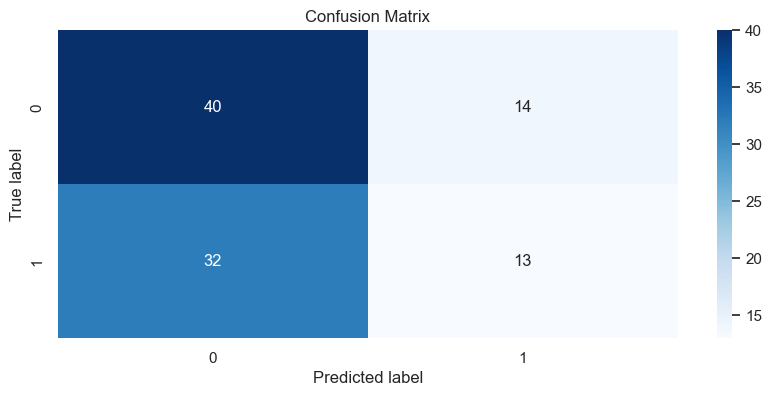

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Build pipeline
clf = Pipeline([
    ('scaler', StandardScaler()),
    ('logit', LogisticRegression(max_iter=1000))
])

# Fit pipeline
clf.fit(X_tr, y_tr_clf)

# Predict on test set
predc = clf.predict(X_te)

# Classification metrics
print(classification_report(y_te_clf, predc))

# Confusion matrix plot
cm = confusion_matrix(y_te_clf, predc)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


## Interpretation

- **What worked:**  
  The pipeline successfully scaled the features and applied logistic regression to predict the next-step direction. The lag, rolling mean, and momentum features capture short-term trends and provided some predictive signal.

- **Where assumptions might fail:**  
  - Logistic regression assumes linear separability in the feature space; in reality, returns might be highly non-linear and noisy.  
  - Features like rolling mean and momentum rely on short windows, which may not generalize well during volatile periods.  
  - Class imbalance or random jumps in returns can reduce recall for the "up" class.

- **How to extend features or model:**  
  - Include longer lags, rolling standard deviations, or z-scores to capture volatility patterns.  
  - Try non-linear models (Decision Trees, Random Forests) or ensemble methods.  
  - Use cross-validation with a time-aware split for more robust performance evaluation.
